In [109]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from graspologic.embed import ClassicalMDS
from sklearn.manifold import MDS

import matplotlib
font = {'size':18}
matplotlib.rc('font', **font)
matplotlib.rcParams['figure.facecolor'] = 'white'
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

from joblib import Parallel, delayed

from llm_work.functions import generate_gaussian_parity, sample_from_F, sample_from_G

In [110]:
# sample_from_F = lambda n : generate_gaussian_parity(n, cluster_std=0.35)
# sample_from_G = lambda n : generate_gaussian_parity(n, cluster_std=0.35, angle_params=np.pi/6)

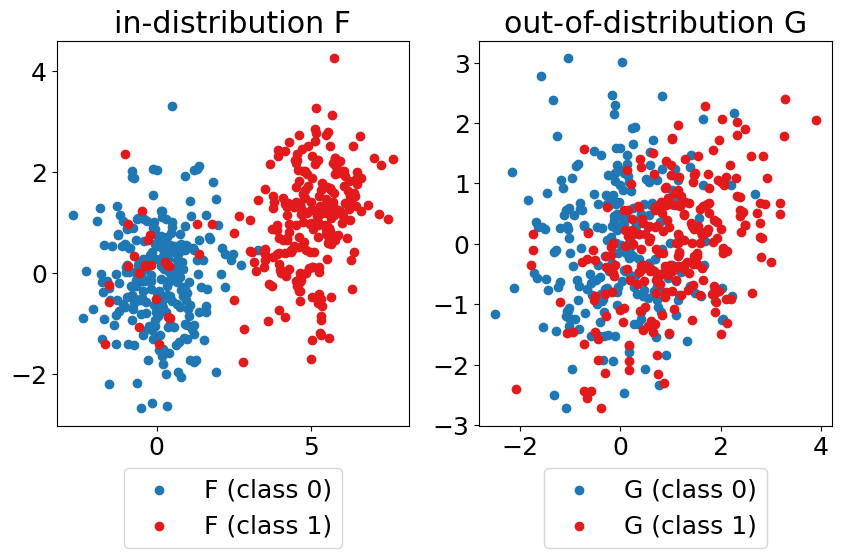

In [111]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
colors = sns.color_palette("Paired")
colors = [colors[1], colors[5]]

labels = ['F (class 0)', 'F (class 1)']
x_in, y_in = sample_from_F(500)
for i, label in enumerate(labels):
    ax[0].scatter(x_in[y_in == i][:, 0], x_in[y_in == i][:, 1], color=colors[i], label=label)
ax[0].legend(loc=8, bbox_to_anchor=(0.5, -0.35))
ax[0].set_title('in-distribution F')

labels = ['G (class 0)', 'G (class 1)']
x_out, y_out = sample_from_G(500)
for i, label in enumerate(labels):
    ax[1].scatter(x_out[y_out == i][:, 0], x_out[y_out == i][:, 1], color=colors[i], label=label)
ax[1].legend(loc=8, bbox_to_anchor=(0.5, -0.35))
ax[1].set_title('out-of-distribution G')
plt.show()

In [112]:
n = 10 # number of seeds
num_trees_ = [50, 100, 500, 1000]
J = len(num_trees_)
F_num_train_ = 500
F_num_test_ = 500
G_num_eval_ = 100
G_num_test_ = 500

In [113]:
xF_train, yF_train = sample_from_F(F_num_train_)
xF_test, yF_test = sample_from_F(F_num_test_)

xG_eval, yG_eval = sample_from_G(G_num_eval_)
xG_test, yG_test = sample_from_G(G_num_test_)

In [114]:
rf_models = []
Lhat = []
Lhatood = []
posteriors = []
for i, num_trees in enumerate(num_trees_):
    for j in range(n):
        seed = 1000 + 100*j
        clf = RandomForestClassifier(n_estimators=num_trees, random_state=seed)
        clf.fit(xF_train, yF_train)
        rf_models.append(clf)
        
        yF_pred = clf.predict(xF_test)
        Lhat_ij_ = np.mean(yF_pred != yF_test)
        Lhat.append(Lhat_ij_)

        yG_pred = clf.predict(xG_test)
        Lhatood_ij_ = np.mean(yG_pred != yG_test)
        Lhatood.append(Lhatood_ij_)

        posteriors.append(clf.predict_proba(xG_eval))
        
posteriors = np.array(posteriors)
Lhat = np.array(Lhat)
Lhatood = np.array(Lhatood)

In [115]:
distance_matrix = np.zeros((n*J, n*J))
for i in range(n*J):
    for j in range(n*J):
        dist_ij_ = np.linalg.norm(posteriors[i] - posteriors[j], ord='fro')
        distance_matrix[i, j] = dist_ij_

In [116]:
mds = MDS(n_components=2, dissimilarity='precomputed', normalized_stress='auto')
X = mds.fit_transform(distance_matrix)

# cmds = ClassicalMDS(n_components=2, dissimilarity='precomputed')
# X = cmds.fit_transform(distance_matrix)

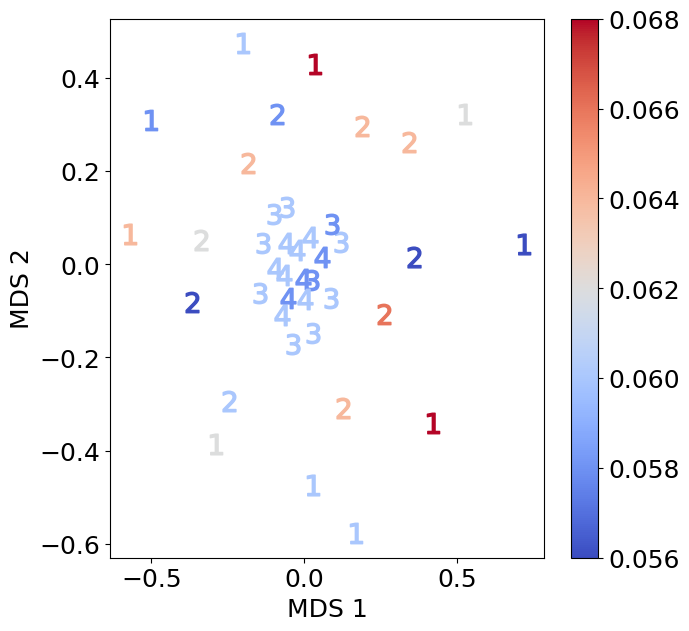

In [117]:
fig, ax = plt.subplots(figsize=(7, 7))
cmap = sns.color_palette("coolwarm", as_cmap=True)
symbols_ = []
for i in range(1, J+1):
    symbols_ += list((i * np.ones(n)).astype('int'))
for x1, x2, symbol, color, size in zip(X[:, 0], X[:, 1], symbols_, Lhat, Lhatood):
    im = ax.scatter(x1, x2, marker=f'${str(symbol)}$', s=size*500, c=color, cmap=cmap, vmin=min(Lhat), vmax=max(Lhat))
plt.colorbar(im, ax=ax, format='%.3f')
ax.set_xlabel('MDS 1')
ax.set_ylabel('MDS 2')
plt.show()